In [2]:
# Install dependencies
# !pip install femwell

In [3]:


from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial import Polynomial
from scipy.constants import speed_of_light
from shapely.geometry import box
from shapely.ops import clip_by_rect
from skfem import Basis, ElementTriP0
from skfem.io.meshio import from_meshio
from tqdm import tqdm

from femwell.maxwell.waveguide import compute_modes
from femwell.mesh import mesh_from_OrderedDict

In [4]:
def n_silicon_nitride(wavelength):
    x = wavelength
    return (1 + 3.0249 / (1 - (0.1353406 / x) ** 2) + 40314 / (1 - (1239.842 / x) ** 2)) ** 0.5


def n_silicon_dioxide(wavelength):
    x = wavelength
    return (
        1
        + 0.6961663 / (1 - (0.0684043 / x) ** 2)
        + 0.4079426 / (1 - (0.1162414 / x) ** 2)
        + 0.8974794 / (1 - (9.896161 / x) ** 2)
    ) ** 0.5



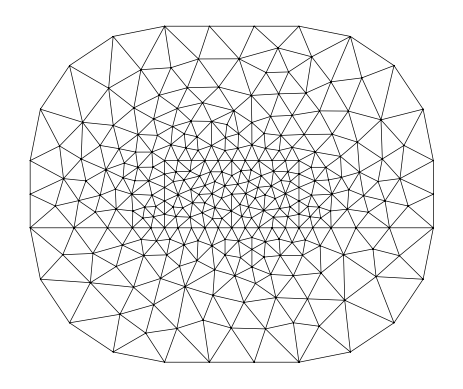

In [5]:
width = 1
height = 0.5
core = box(0, 0, width, height)
polygons = OrderedDict(
    core=core,
    box=clip_by_rect(core.buffer(1.0, resolution=4), -np.inf, -np.inf, np.inf, 0),
    clad=clip_by_rect(core.buffer(1.0, resolution=4), -np.inf, 0, np.inf, np.inf),
)

resolutions = {"core": {"resolution": 0.1, "distance": 1}}

mesh = from_meshio(mesh_from_OrderedDict(polygons, resolutions, default_resolution_max=0.6))
mesh.draw().show()

In [6]:
wavelengths = np.linspace(1.2, 1.9, 20)
num_modes = 2

all_neffs = np.zeros((wavelengths.shape[0], num_modes))
all_te_fracs = np.zeros((wavelengths.shape[0], num_modes))
for i, wavelength in enumerate(tqdm(wavelengths)):
    basis0 = Basis(mesh, ElementTriP0())
    epsilon = basis0.zeros(dtype=complex)
    for subdomain, n in {
        "core": n_silicon_nitride(wavelength),
        "box": n_silicon_dioxide(wavelength),
        "clad": 1,
    }.items():
        epsilon[basis0.get_dofs(elements=subdomain)] = n**2

    modes = compute_modes(basis0, epsilon, wavelength=wavelength, num_modes=num_modes)
    all_neffs[i] = np.real([mode.n_eff for mode in modes])
    all_te_fracs[i, :] = [mode.te_fraction for mode in modes]

100%|██████████| 20/20 [00:01<00:00, 11.84it/s]


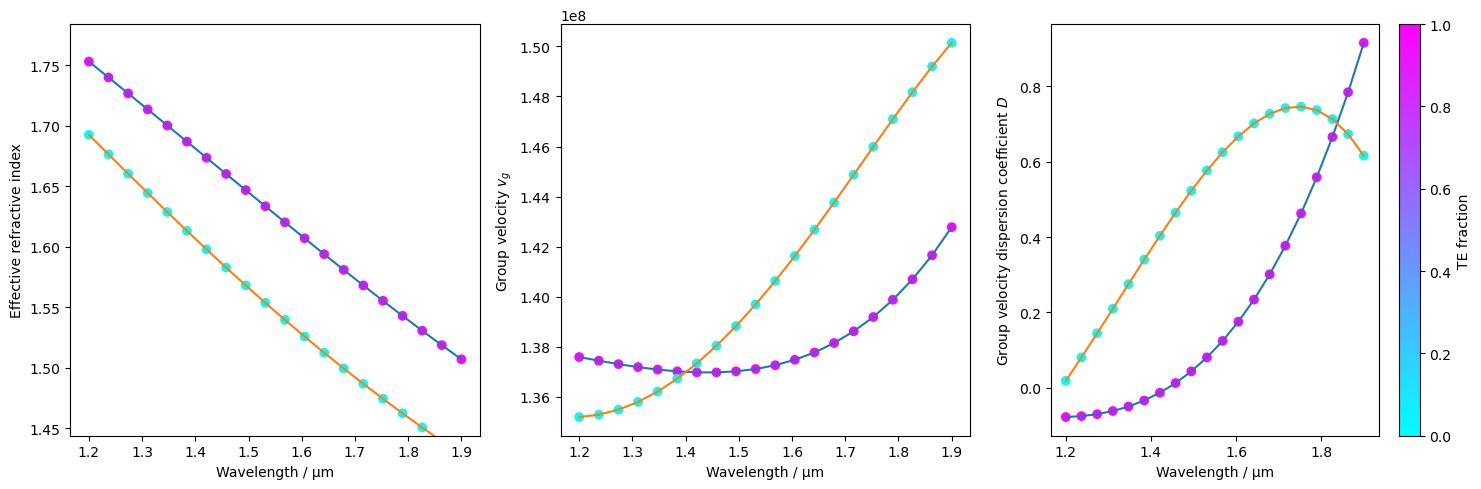

In [7]:
all_neffs = np.real(all_neffs)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].set_xlabel("Wavelength / µm")
axs[0].set_ylabel("Effective refractive index")
axs[0].set_ylim(1.444, np.max(all_neffs) + 0.1 * (np.max(all_neffs) - 1.444))
for lams, te_fracs in zip(all_neffs.T, all_te_fracs.T):
    axs[0].plot(wavelengths, lams)
    sc = axs[0].scatter(wavelengths, lams, c=te_fracs, cmap="cool", vmin=0, vmax=1)


axs[1].set_xlabel("Wavelength / µm")
axs[1].set_ylabel("Group velocity $v_g$")
for lams, te_fracs in zip(all_neffs.T, all_te_fracs.T):
    fit = Polynomial.fit(wavelengths, lams, deg=4)
    y = speed_of_light / (lams - wavelengths * fit.deriv(1)(wavelengths))
    axs[1].plot(wavelengths, y)
    sc = axs[1].scatter(wavelengths, y, c=te_fracs, cmap="cool", vmin=0, vmax=1)

axs[2].set_xlabel("Wavelength / µm")
axs[2].set_ylabel("Group velocity dispersion coefficient $D$")
for lams, te_fracs in zip(all_neffs.T, all_te_fracs.T):
    fit = Polynomial.fit(wavelengths, lams, deg=4)
    y = wavelengths**2 * fit.deriv(2)(wavelengths)
    axs[2].plot(wavelengths, y)
    sc = axs[2].scatter(wavelengths, y, c=te_fracs, cmap="cool", vmin=0, vmax=1)
fig.colorbar(sc).set_label("TE fraction")
plt.tight_layout()
plt.show()

### Group Velocity Dispersion 

In [8]:
import math
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
from scipy.interpolate import UnivariateSpline
from skfem import Basis, ElementTriP0
from skfem.io import from_meshio
from tqdm import tqdm

from femwell.maxwell.waveguide import compute_modes
from femwell.mesh import mesh_from_OrderedDict
from femwell.visualization import plot_domains

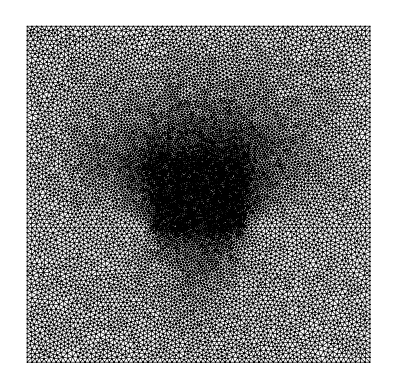

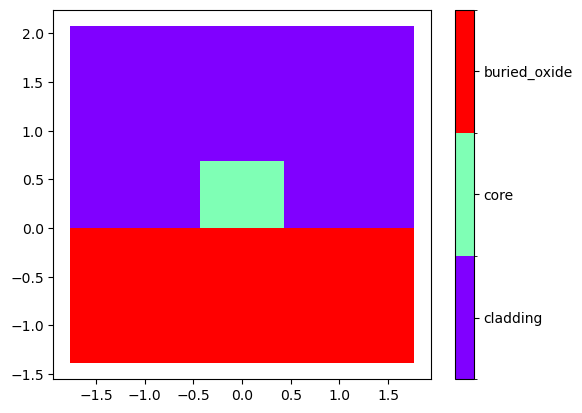

In [9]:
width = 0.88  # um
height = 0.69  # um

wavelength_range = [500, 2500]
wavelegnth_step = 50

# Construct waveguide geometry
core = shapely.geometry.box(-width / 2, 0, +width / 2, height)
cladding = shapely.geometry.box(-width * 2, 0, width * 2, height * 3)
buried_oxide = shapely.geometry.box(-width * 2, -height * 2, width * 2, 0)
polygon = OrderedDict(
    core=core,
    cladding=cladding,
    buried_oxide=buried_oxide,
)

# Define material property and resolution of waveguide
resolutions = dict(
    core={"resolution": 0.02, "distance": 0.3},
    cladding={"resolution": 0.05, "distance": 0.3},
    buried_oxide={"resolution": 0.05, "distance": 0.3},
)

mesh = from_meshio(mesh_from_OrderedDict(polygon, resolutions, default_resolution_max=2))
mesh.draw().show()
plot_domains(mesh)
plt.show()

In [10]:
def n_Si3N4(wavelength, fit=False):
    if wavelength >= 0.31 and wavelength <= 5.507:
        return math.sqrt(
            (3.0249 * wavelength**2) / (wavelength**2 - 0.1353406**2)
            + (40314 * wavelength**2) / (wavelength**2 - 1239.842**2)
            + 1
        )
    else:
        raise ValueError(f"wavelength provided is {wavelength}um, is out of the range for Si3N4")


def n_SiO2(wavelength):
    if wavelength < 0.21 or wavelength > 6.7:
        raise ValueError(f"wavelength provided is {wavelength}um, is out of the range for {type}")
    return np.sqrt(
        0.6961663 * wavelength**2 / (wavelength**2 - 0.0684043**2)
        + (0.4079426 * wavelength**2 / (wavelength**2 - 0.1162414**2))
        + (0.8974794 * wavelength**2 / (wavelength**2 - 9.896161**2))
        + 1
    )


n_dict = {"core": n_Si3N4, "cladding": n_SiO2, "buried_oxide": n_SiO2}

In [11]:
neff_list = []
aeff_list = []
basis0 = Basis(mesh, ElementTriP0())
epsilon = basis0.zeros()
wavelength_list = np.linspace(wavelength_range[0], wavelength_range[1], wavelegnth_step)

for wavelength in tqdm(wavelength_list):
    wavelength = wavelength * 1e-3
    for subdomain, n in n_dict.items():
        epsilon[basis0.get_dofs(elements=subdomain)] = n(wavelength) ** 2

    modes = compute_modes(basis0, epsilon, wavelength=wavelength, num_modes=3, order=1)
    modes_sorted = modes.sorted(key=lambda mode: -np.real(mode.te_fraction))
    mode = modes_sorted[0]

    neff_list.append(np.real(mode.n_eff))
    aeff_list.append(np.real(mode.calculate_effective_area()))

100%|██████████| 50/50 [04:13<00:00,  5.07s/it]


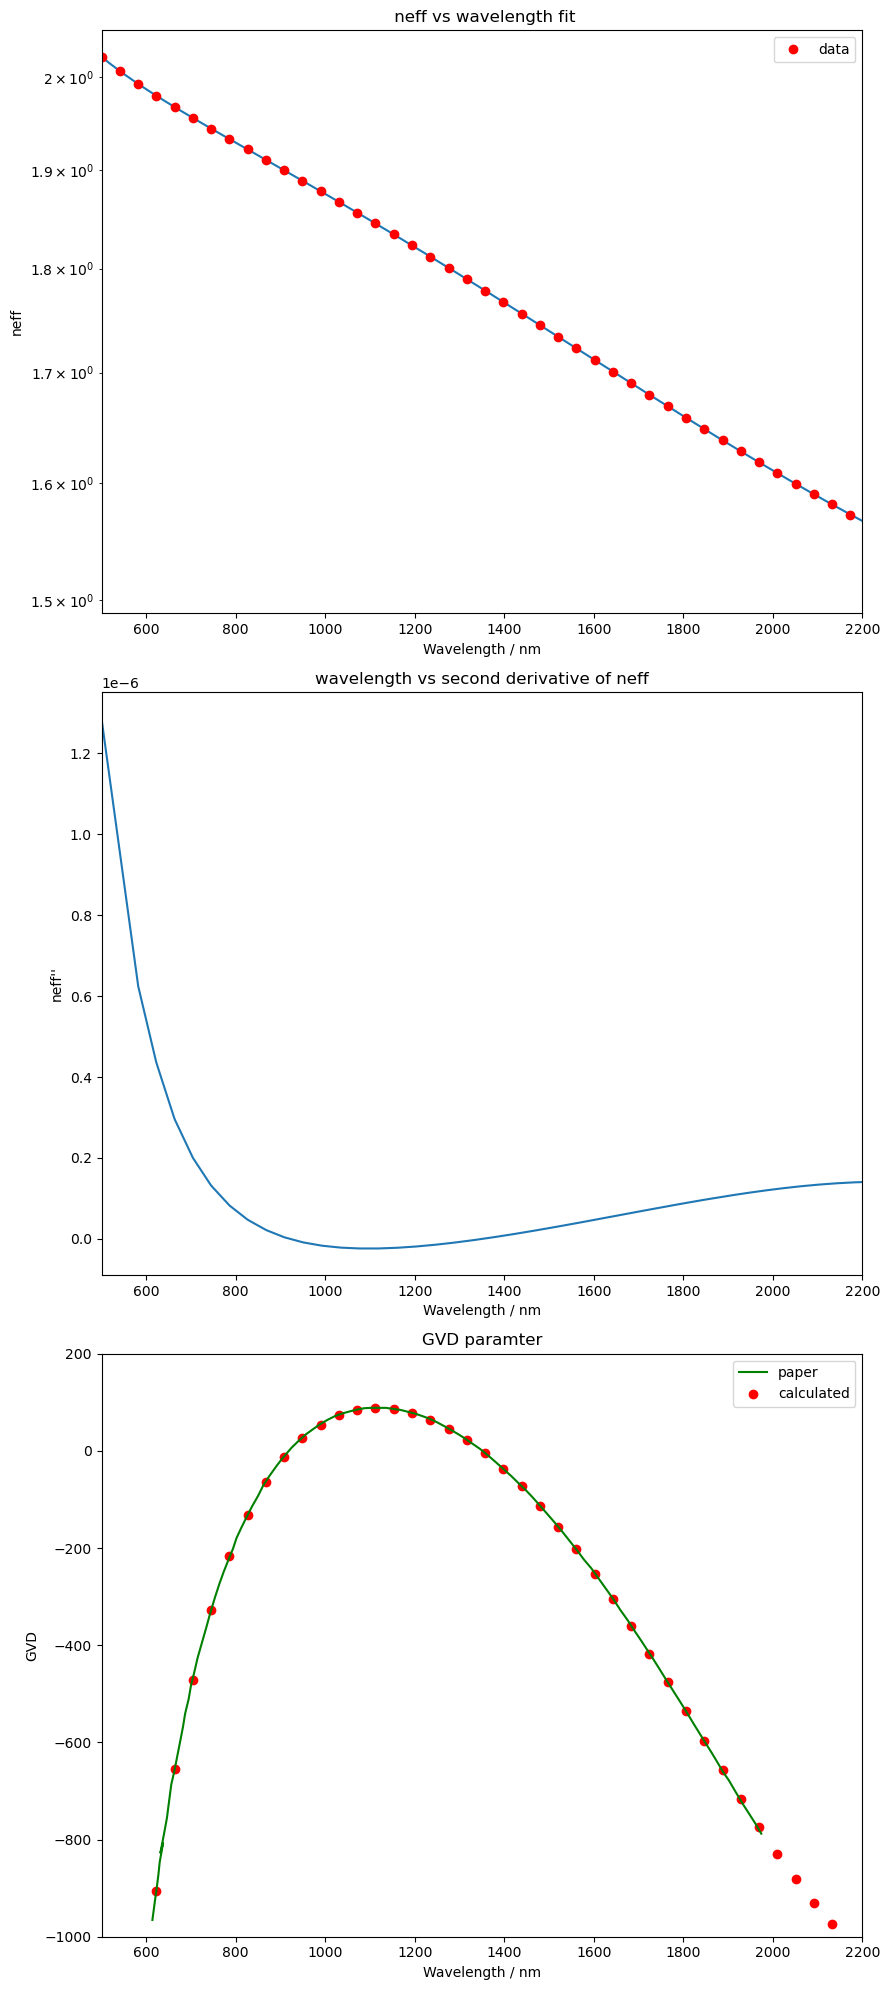

In [14]:
y_spl = UnivariateSpline(wavelength_list, neff_list, s=0, k=3)
x_range = np.linspace(wavelength_list[0], wavelength_list[-1], 1000)
y_spl_2d = y_spl.derivative(n=2)

# Plot the result
fig, axs = plt.subplots(3, 1, figsize=(9, 20))

axs[0].set_xlabel("Wavelength / nm")
axs[0].set_ylabel("neff")
axs[0].set_title(" neff vs wavelength fit")
axs[0].semilogy(x_range, y_spl(x_range))
axs[0].semilogy(wavelength_list, neff_list, "ro", label="data")
axs[0].legend()
axs[0].set_xlim(500, 2200)

axs[1].set_xlabel("Wavelength / nm")
axs[1].set_ylabel("neff''")
axs[1].set_title("wavelength vs second derivative of neff")
axs[1].plot(x_range, y_spl_2d(x_range))
axs[1].set_xlim(500, 2200)

# ----plot reference data-------
ref_gvd = pd.read_csv("./reference_data/Klenner/GVD.csv", dtype=np.float64)
ref_gvd_x, ref_gvd_y = np.split(ref_gvd.values, 2, axis=1)
axs[2].plot(ref_gvd_x, ref_gvd_y, c="green", label="paper")

# ----Calculate and plot GVD
GVD = -wavelength_list / (2.99792e-7) * y_spl_2d(wavelength_list)
axs[2].scatter(wavelength_list, GVD, label="calculated", c="red")

axs[2].set_ylabel("GVD")
axs[2].set_xlabel("Wavelength / nm")
axs[2].set_ylim(-1000, 200)
axs[2].set_xlim(500, 2200)
axs[2].set_title("GVD paramter")
axs[2].legend()

plt.tight_layout()
plt.show()

In [ ]:
### Fiber to Waveguide

In [16]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
from shapely import box
from skfem import Basis, ElementTriP0, ElementTriP1
from skfem.io import from_meshio
from tqdm import tqdm

from femwell.fiber import e_field_gaussian, overlap
from femwell.maxwell.waveguide import compute_modes
from femwell.mesh import mesh_from_OrderedDict

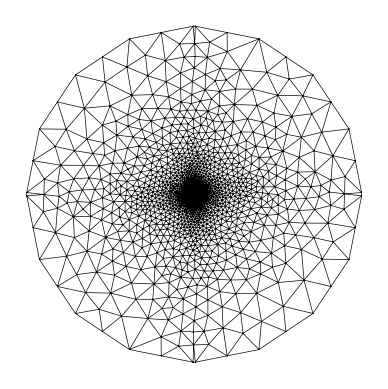

In [17]:
core = box(-0.1, -0.15, 0.1, 0.15)
polygons = OrderedDict(core=core, clad=core.buffer(15, resolution=4))

resolutions = dict(core={"resolution": 0.01, "distance": 0.1})
mesh = from_meshio(mesh_from_OrderedDict(polygons, resolutions, default_resolution_max=10))
mesh.draw().show()

In [21]:
basis0 = Basis(mesh, ElementTriP0(), intorder=4)
epsilon = basis0.zeros().astype(complex)
epsilon[basis0.get_dofs(elements="core")] = 1.9963**2
epsilon[basis0.get_dofs(elements="clad")] = 1.444**2
# basis0.plot(np.real(epsilon), colorbar=True).show()

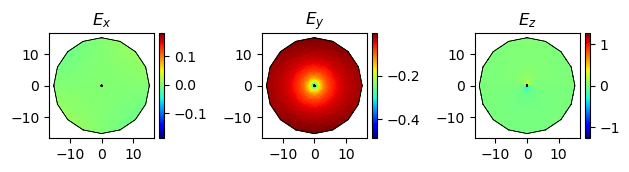

In [31]:
modes = compute_modes(basis0, epsilon, wavelength=1.55, mu_r=1, num_modes=1)

fig, axs = modes[0].plot(modes[0].E.real, direction="x")
# plt.tight_layout()
plt.show()

In [23]:
# we sweep the mode-field-diameter of the fiber to see the dependence of the coupling on the MFD. 
# As the waveguide is asymmetric, we get non-hybridized modes, i.e. either TE- or TM-modes. 
# Thus, it’s sufficient to calculate the overlap with the non-zero in-plane component.

100%|██████████| 100/100 [00:06<00:00, 15.23it/s]


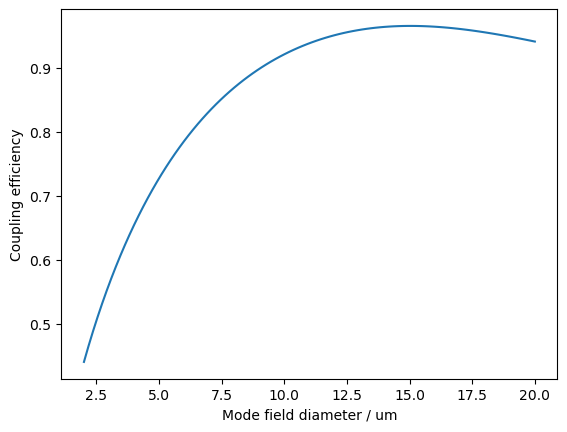

In [24]:
mfds = np.linspace(2, 20, 100)
efficiencies = []

for mfd in tqdm(mfds):
    basis_fiber = basis0.with_element(ElementTriP1())
    x_fiber = basis_fiber.project(
        lambda x: e_field_gaussian(np.sqrt(x[0] ** 2 + x[1] ** 2), 0, mfd / 2, 1, 1.55),
        dtype=complex,
    )

    efficiency = overlap(
        basis_fiber, modes[0].basis.interpolate(modes[0].E)[0][1], basis_fiber.interpolate(x_fiber)
    )
    efficiencies.append(efficiency)

plt.plot(mfds, efficiencies)
plt.xlabel("Mode field diameter / um")
plt.ylabel("Coupling efficiency")
plt.show()